In [0]:
## Word 2 Vec с нуля

In [0]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

split_ind = (int)(len(text) * 0.8)

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(text)
vocab_size = len(vocab)
print('vocab_size:', vocab_size)

w2i = {w: i for i, w in enumerate(vocab)}
i2w = {i: w for i, w in enumerate(vocab)}

vocab_size: 49


In [0]:
# context window size is two
def create_cbow_dataset(text):
    data = []
    for i in range(2, len(text) - 2):
        context = [text[i - 2], text[i - 1],
                   text[i + 1], text[i + 2]]
        target = text[i]
        data.append((context, target))
    return data

def create_skipgram_dataset(text):
    import random
    data = []
    for i in range(2, len(text) - 2):
        data.append((text[i], text[i-2], 1))
        data.append((text[i], text[i-1], 1))
        data.append((text[i], text[i+1], 1))
        data.append((text[i], text[i+2], 1))
        # negative sampling
        for _ in range(4):
            if random.random() < 0.5 or i >= len(text) - 3:
                rand_id = random.randint(0, i-1)
            else:
                rand_id = random.randint(i+3, len(text)-1)
            data.append((text[i], text[rand_id], 0))
    return data

cbow_train = create_cbow_dataset(text)
skipgram_train = create_skipgram_dataset(text)
print('cbow sample', cbow_train[0])
print('skipgram sample', skipgram_train[0])

cbow sample (['We', 'are', 'to', 'study'], 'about')
skipgram sample ('about', 'We', 1)


In [0]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out)
        return log_probs

class SkipGram(nn.Module):
    def __init__(self, vocab_size, embd_size):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
    
    def forward(self, focus, context):
        embed_focus = self.embeddings(focus).view((1, -1))
        embed_ctx = self.embeddings(context).view((1, -1))
        score = torch.mm(embed_focus, torch.t(embed_ctx))
        log_probs = F.logsigmoid(score)
    
        return log_probs

In [0]:
embd_size = 100
learning_rate = 0.001
n_epoch = 30

def train_cbow():
    hidden_size = 64
    losses = []
    loss_fn = nn.NLLLoss()
    model = CBOW(vocab_size, embd_size, CONTEXT_SIZE, hidden_size)
    print(model)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(n_epoch):
        total_loss = .0
        for context, target in cbow_train:
            ctx_idxs = [w2i[w] for w in context]
            ctx_var = Variable(torch.LongTensor(ctx_idxs))

            model.zero_grad()
            log_probs = model(ctx_var)

            loss = loss_fn(log_probs, Variable(torch.LongTensor([w2i[target]])))

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        losses.append(total_loss)
    return model, losses

def train_skipgram():
    losses = []
    loss_fn = nn.MSELoss()
    model = SkipGram(vocab_size, embd_size)
    print(model)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(n_epoch):
        total_loss = .0
        for in_w, out_w, target in skipgram_train:
            in_w_var = Variable(torch.LongTensor([w2i[in_w]]))
            out_w_var = Variable(torch.LongTensor([w2i[out_w]]))
            
            model.zero_grad()
            log_probs = model(in_w_var, out_w_var)
            loss = loss_fn(log_probs[0], Variable(torch.Tensor([target])))
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        losses.append(total_loss)
    return model, losses
    
cbow_model, cbow_losses = train_cbow()
sg_model, sg_losses = train_skipgram()

CBOW(
  (embeddings): Embedding(49, 100)
  (linear1): Linear(in_features=400, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=49, bias=True)
)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


SkipGram(
  (embeddings): Embedding(49, 100)
)


In [0]:
def test_cbow(test_data, model):
    print('====Test CBOW===')
    correct_ct = 0
    for ctx, target in test_data:
        ctx_idxs = [w2i[w] for w in ctx]
        ctx_var = Variable(torch.LongTensor(ctx_idxs))

        model.zero_grad()
        log_probs = model(ctx_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted_word = i2w[predicted.item()]
        print('predicted:', predicted_word)
        print('label    :', target)
        if predicted_word == target:
            correct_ct += 1
            
    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

def test_skipgram(test_data, model):
    print('====Test SkipGram===')
    correct_ct = 0
    for in_w, out_w, target in test_data:
        in_w_var = Variable(torch.LongTensor([w2i[in_w]]))
        out_w_var = Variable(torch.LongTensor([w2i[out_w]]))

        model.zero_grad()
        log_probs = model(in_w_var, out_w_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted = predicted.item()
        if predicted == target:
            correct_ct += 1

    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

test_cbow(cbow_train, cbow_model)
print('------')
test_skipgram(skipgram_train, sg_model)

====Test CBOW===
predicted: about
label    : about
predicted: to
label    : to
predicted: study
label    : study
predicted: the
label    : the
predicted: idea
label    : idea
predicted: of
label    : of
predicted: a
label    : a
predicted: computational
label    : computational
predicted: process.
label    : process.
predicted: Computational
label    : Computational
predicted: processes
label    : processes
predicted: are
label    : are
predicted: abstract
label    : abstract
predicted: beings
label    : beings
predicted: that
label    : that
predicted: inhabit
label    : inhabit
predicted: computers.
label    : computers.
predicted: As
label    : As
predicted: they
label    : they
predicted: evolve,
label    : evolve,
predicted: processes
label    : processes
predicted: manipulate
label    : manipulate
predicted: other
label    : other
predicted: abstract
label    : abstract
predicted: things
label    : things
predicted: called
label    : called
predicted: data.
label    : data.
predi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


<Figure size 432x288 with 0 Axes>

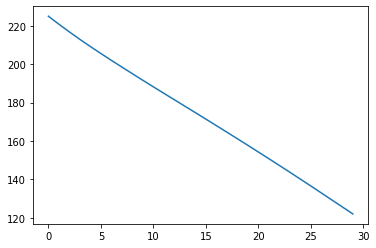

<Figure size 432x288 with 0 Axes>

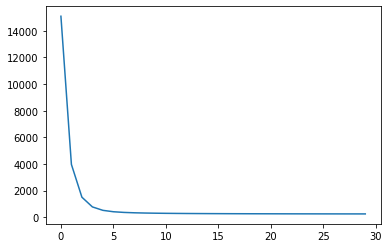

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def showPlot(points, title):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)

showPlot(cbow_losses, 'CBOW Losses')
showPlot(sg_losses, 'SkipGram Losses')

In [0]:
## GenSim с нуля

In [0]:
from gensim.models import Word2Vec
# define training data
sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
			['this', 'is', 'the', 'second', 'sentence'],
			['yet', 'another', 'sentence'],
			['one', 'more', 'sentence'],
			['and', 'the', 'final', 'sentence']]
# train model
model = Word2Vec(sentences, min_count=1)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)
# access vector for one word
print(model['sentence'])
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)


Word2Vec(vocab=14, size=100, alpha=0.025)
['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec', 'second', 'yet', 'another', 'one', 'more', 'and', 'final']
[ 3.2323442e-04  2.5678647e-03 -3.0831203e-03  3.7915867e-03
 -3.6789417e-05  1.5845978e-04  3.4413277e-03 -9.3107385e-04
  4.0244414e-03 -8.6038216e-04 -1.3498807e-03 -3.1899237e-03
  5.3109846e-04  1.4707999e-03  3.2714910e-03  1.5496209e-03
  2.0806002e-03  9.8193146e-04 -4.5805024e-03 -3.9414871e-03
  4.2560645e-03  2.5280481e-03  3.8394475e-04 -2.2159489e-03
 -1.2933323e-03 -2.8741164e-03  2.2977332e-03 -4.2318855e-03
 -1.5693028e-03  3.2724778e-03 -4.7255713e-03  2.5719984e-03
 -2.3946026e-03 -9.2625624e-04  2.2458287e-03 -2.7362334e-03
  3.0132993e-03 -2.1682628e-03 -2.2048098e-03 -2.5001381e-04
  3.1834452e-03  1.4372513e-03 -3.0151962e-03 -3.1306276e-03
  1.7316741e-03 -2.8816236e-03 -3.9042006e-03 -2.4219212e-04
  4.2849644e-03  2.6485389e-03 -1.6021084e-03 -1.8433586e-03
 -1.4459206e-03 -2.4519088e-03 -3.4791550e-0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
X = model[model.wv.vocab]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result = pca.fit_transform(X)

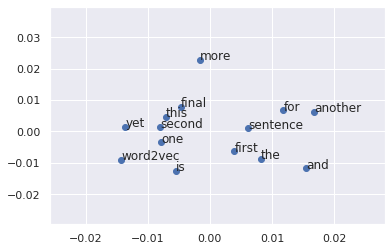

In [0]:
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [0]:
## Gensim готовый

In [0]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2019-12-15 16:48:58--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.129.53
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.129.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  84.3MB/s    in 17s     

2019-12-15 16:49:14 (93.1 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
from gensim.models import KeyedVectors
# load the google word2vec model
filename = 'GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(filename, binary=True)
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=10)
print(result)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('queen', 0.7118192911148071), ('monarch', 0.6189674139022827), ('princess', 0.5902431011199951), ('crown_prince', 0.5499460697174072), ('prince', 0.5377321243286133), ('kings', 0.5236844420433044), ('Queen_Consort', 0.5235945582389832), ('queens', 0.518113374710083), ('sultan', 0.5098593235015869), ('monarchy', 0.5087411999702454)]


In [0]:
## Домашнее задание
1. Скачать датасет с фразами симпосонов - https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data
2. Обучить word2vec на фразах персонажей
3. Построить word cloud по самым частотным словам (top 1000)
4. Найти самые близкие слова для:
  homer - marge + bart
  bart - lisa + school
  marge - homer + home

SyntaxError: ignored